In [1]:
import joblib
import sys
sys.path.extend(['../../../config', '../../../app/utils'])

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve

from preprocessing_utils import one_hot_encoding

RANDOM_STATE = 123

## Загрузка и предобработка данных

In [2]:
# Загрузка данных
df = pd.read_csv('./train_test_cleaned.csv', low_memory=False)
df_train = df[df.target.notna()].copy()
df_train['target'] = df_train['target'].astype('bool')
x_train = df_train.drop(['sk_id_curr', 'target'], axis=1)
y_train = df_train.target

numerical_columns = []
categorical_columns = []
for column in df_train.drop(['sk_id_curr', 'target'], axis=1).columns:
    if pd.api.types.is_object_dtype(df_train[column]) or pd.api.types.is_bool_dtype(df_train[column]):
        categorical_columns.append(column)
    else: numerical_columns.append(column)

In [3]:
# One-Hot Encoding категориальных признаков
x_train = one_hot_encoding(x_train, categorical_columns)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, 
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    stratify=y_train, 
                                                    random_state=RANDOM_STATE)

In [5]:
scaler = StandardScaler()
x_train.loc[:, numerical_columns] = scaler.fit_transform(x_train[numerical_columns])
x_test.loc[:, numerical_columns] = scaler.transform(x_test[numerical_columns])

## Обучение моделей

In [6]:
# Загрузка моделей
tree = joblib.load('decision_tree.pkl')
logr = joblib.load('logistic_regression.pkl')

In [7]:
tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=8, max_features=0.4,
                       min_samples_leaf=16, min_samples_split=5)

In [8]:
logr.fit(x_train, y_train)

LogisticRegression(C=1.81, class_weight='balanced', max_iter=137,
                   solver='newton-cholesky')

In [9]:
proba_tree, pred_tree = tree.predict_proba(x_test), tree.predict(x_test)
proba_logr, pred_logr = logr.predict_proba(x_test), logr.predict(x_test)

## Сравнительный анализ моделей

Так-как обучение и предсказания моделей занимает примерно одинаковое время, сравним эффективность и различие между предсказаниями.

- Загрузим модели с подобранными на кросс-валидации гиперпараметрами
- Обучим модели на тренировочном сплите
- Исследуем важность признаков выученных моделями
- Получим предсказания моделей на тестовом сплите
- **Сравним предсказания моделей:**
    - Сравним ROC-AUC моделей
    - С помощью Bootstrap определим, имеется ли статистическая значимость между предсказаниями моделей

### Сравнение важности признаков
Построим столбчатые диаграммы важности признаков для 100 самых важных признаков.

In [10]:
# Создадим датафреймы с важностью признаков
linear_regression_coefs = pd.DataFrame(logr.coef_.reshape(1, -1), columns=logr.feature_names_in_)
tree_importances = pd.DataFrame(tree.feature_importances_.reshape(1, -1), columns=tree.feature_names_in_)


<Figure size 2000x1000 with 0 Axes>

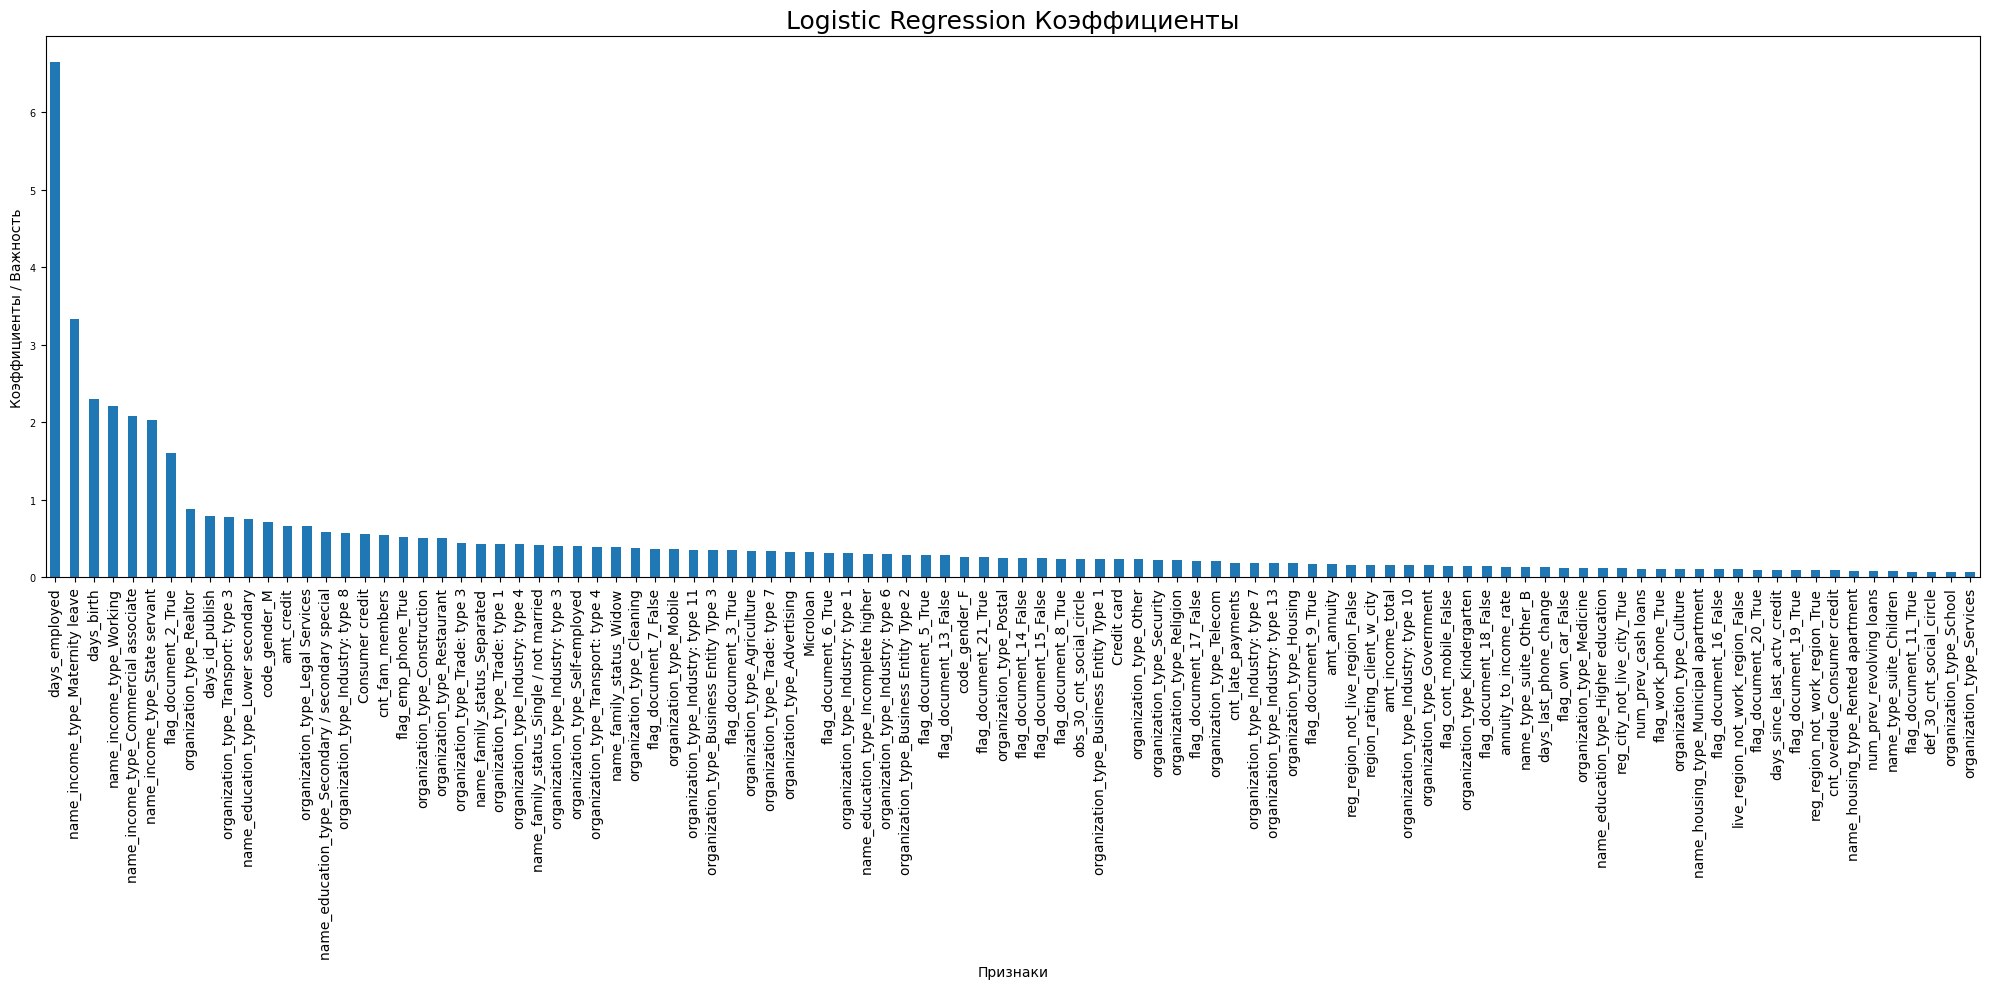

<Figure size 2000x1000 with 0 Axes>

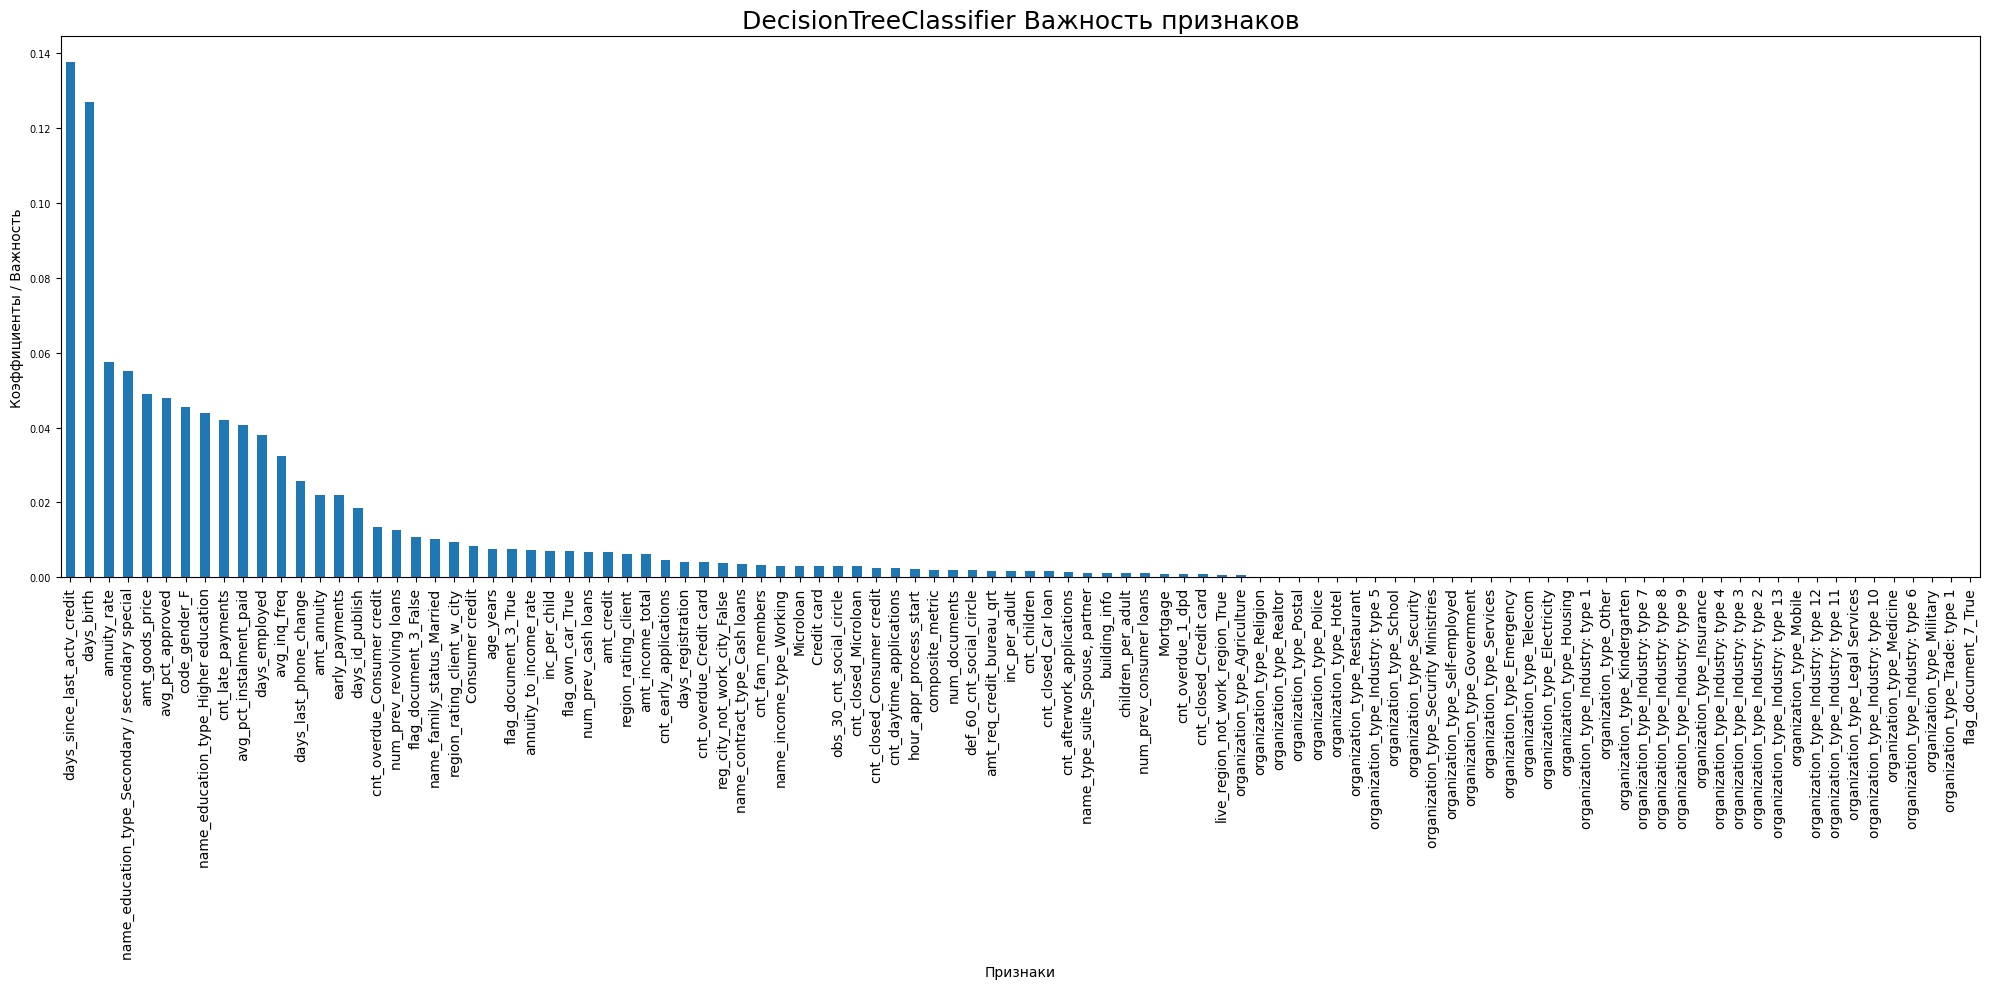

In [11]:
# Построим графики важности
top_features = 100

labels = ['Logistic Regression Коэффициенты', 'DecisionTreeClassifier Важность признаков']
for importance, label in zip([linear_regression_coefs, tree_importances], labels):
    importance = importance.transpose()
    
    # Отсортируем веса, Выберем N top_features
    importance = importance.sort_values(by=0, ascending=False)
    importance = importance.iloc[:top_features]

    plt.figure(figsize=(20, 10))
    importance.plot(kind='bar', legend=False, figsize=(20, 10))
    plt.xlabel('Признаки')
    plt.ylabel('Коэффициенты / Важность')
    plt.title(label, size=18)
    plt.tick_params(axis='y', labelsize=7)
    plt.tight_layout()
    plt.show()


- **LogisticRegression**: Наша модель использует L2 регуляризацию и не зануляет веса не значимых признаков, а уменьшает их, по этому у нас на графике видно плавное снижение важности признаков вплоть до 100-ого и далее. В десятку признаков с наибольшими весами входят:
    - Трудовой стаж
    - Занятость = Декрет (2ое место)
    - Другие типы занятости
    - Возраст заёмщика
    - Пол заёмщика
 
- **DecisionTreeClassifier**: Важность признаков в решающем дереве определяется насколько часто сплит по тоиу или иному признак приводил к наибольшему снижению *impurity* (в случае выбора метриков *gini impurity*). Другими словами - наиболее важный признак - это тот признак по которому чаще всего был произведен сплит, и так далее по убыванию. Таким образом, часть признаков может вообще не участвовать в качестве признака по которому был произведен сплит и иметь нулевую важность по мнению модели. В десятку самых важных признаков входят:
    - Время с момента взятия последнего активного кредита
    - Возраст
    - Ставка кредита
    - Категория образование = Высшее образование
    - Трудовой стаж
    - Количество просрочек по платежам
 
Данная информация может быть использована разработчиками и бизнесом для:
- Упрощения модели: посредством исключения наименее важных признаков
- Калибровка модели: с целью избежания предвзятости по половому, национальному, религиозному и другим признакам
- Извлечение инсайтов:
    - Использование информации для принятия решений в рамках стратегического планирования бизнесом
    - Извлечение информации о наиболее и наименее важных (по мнению модели) маркеров дефолта
- ...
- И другое

При необходимости, более глубокий анализ влияния признаков на предсказания модели может быть произведён при помощи библиотеки **SHAP**.

### Сравнение ROC-AUC моделей

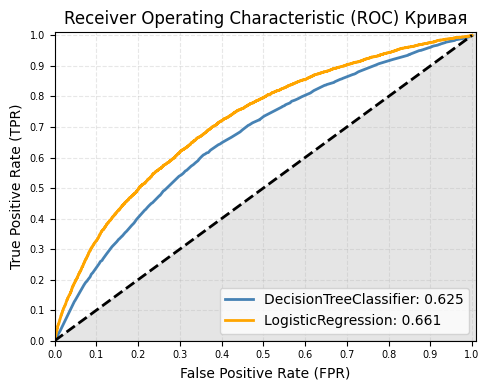

In [12]:
rauc_tree = roc_auc_score(y_test, pred_tree).round(3)
rauc_logr = roc_auc_score(y_test, pred_logr).round(3)

tree_fpr, tree_tpr, tree_thresholds = roc_curve(y_test, proba_tree[:,1])
logr_fpr, logr_tpr, logr_thresholds = roc_curve(y_test, proba_logr[:,1])

plt.figure(figsize=(5, 4))
plt.plot(tree_fpr, tree_tpr, linewidth=2, c='steelblue', label=f'DecisionTreeClassifier: {rauc_tree}')
plt.plot(logr_fpr, logr_tpr, linewidth=2, c='orange', label=f'LogisticRegression: {rauc_logr}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.fill_between([0, 1.01], [0, 1.01], color='gray', alpha=0.2)

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Кривая')
plt.legend(loc="lower right")

plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.yticks(np.arange(0, 1.05, 0.1))
plt.xticks(np.arange(0, 1.05, 0.1))
plt.tick_params(axis='both', labelsize=7)
plt.grid(ls='--', alpha=0.3)
plt.tight_layout()
plt.show()

Как мы можем видеть из графика выше, **LogisticRegression** смогла достичь более высокого показателя ROC-AUC ($\text{0.661}$) при предсказаниях на тестовом сплите, по сравнению с моделью **DecisionTreeClassifier** ($\text{0.618}$).

### Bootstrap.

Выясним, имеется ли статистически значимая разница между предсказанными вероятностями для позитивного класса между моделями, с помощью метода Bootstrap.

- $H_0$: Отсутствует статистически значимая разница между предсказаниями вероятностей для позитивного класса моделей
- $H_1$: Присутствует статистически значимая разница между предсказаниями вероятностей для позитивного класса моделей

In [13]:
boot_means_tree = []
boot_means_logr = []
for boot_iter in tqdm(range(10_000)):

    bootsample_tree = np.random.choice(proba_tree[:,1], size=proba_tree[:,1].shape[0], replace=True)
    bootsample_logr = np.random.choice(proba_logr[:,1], size=proba_logr[:,1].shape[0], replace=True)
    
    tree_sample_mean = np.mean(bootsample_tree)
    logr_sample_mean = np.mean(bootsample_logr)
    
    boot_means_tree.append(tree_sample_mean)
    boot_means_logr.append(logr_sample_mean)

  0%|          | 0/10000 [00:00<?, ?it/s]

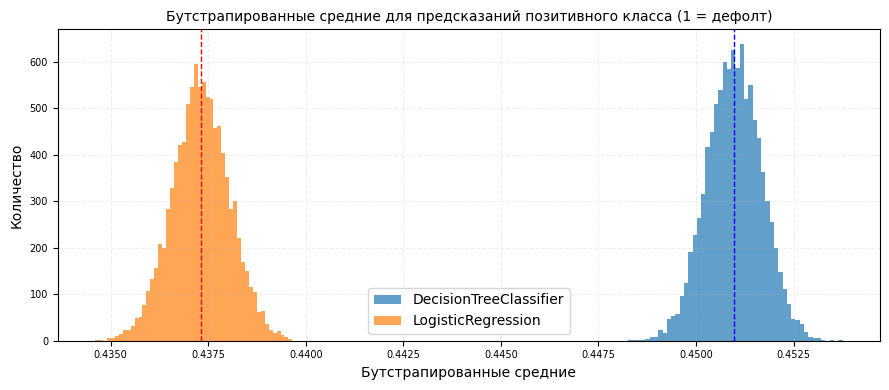

In [14]:
plt.figure(figsize=(9, 4))
plt.hist(boot_means_tree, bins=50, label='DecisionTreeСlassifier', alpha=0.7)
plt.hist(boot_means_logr, bins=50, label='LogisticRegression', alpha=0.7)
plt.axvline(np.mean(boot_means_tree), color='blue', linestyle='--', linewidth=1)
plt.axvline(np.mean(boot_means_logr), color='red', linestyle='--', linewidth=1)

plt.xlabel('Бутстрапированные средние')
plt.ylabel('Количество')
plt.title('Бутстрапированные средние для предсказаний позитивного класса (1 = дефолт)', size=10)

plt.tick_params(axis='both', labelsize=7)
plt.grid(True, ls='--', alpha=0.2)
plt.legend()

plt.tight_layout()
plt.show()

Как мы можем видеть из графика выше, гистограммы распределения средних значений предсказанных вероятностей позитивного класса для моделей LogisticRegression и DecisionTreeClassifier с помощью метода Bootstrap <u>**не пересекаются**</u>, таким образом мы можем смело отвергнуть $H_0$.  

Отвергаем $H_0$ в пользу $H_1$: Присутствует статистически значимая разница между предсказаями вероятностей для позитивного класса.


## Вывод
Обе модели отдают предпочтение схожим признакам при обучении (стаж, тип занятости, возраст, кредитная история), за некоторыми исключениями.

Лучшей моделью признается **LogisticRegression**, так-как она достигла наибольшего показателя ROC-AUC и при этом разница между предсказаниями моделей является статистически значимой (на основании результатов, полученных с помощью метода Bootstrap).